In [56]:
import numpy as np
import pandas as pd
import warnings
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Back, Style
from sklearn.preprocessing import StandardScaler
import itertools
from collections import defaultdict
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, HuberRegressor
import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.model_selection import StratifiedKFold, GroupKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy.stats import pearsonr, spearmanr, rankdata
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
import pickle

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Load data

* _scale(): 對 data 的 features 進行標準化

In [57]:
def _scale(train_data, val_data, test_data, feats):
    scaler = StandardScaler()
    
    scaled_train = scaler.fit_transform(train_data[feats])
    scaled_val = scaler.transform(val_data[feats])
    scaled_test = scaler.transform(test_data[feats])
    
    # back to dataframe
    new_train = train_data.copy()
    new_val = val_data.copy()
    new_test = test_data.copy()
    
    new_train[feats] = scaled_train
    new_val[feats] = scaled_val
    new_test[feats] = scaled_test
    
    assert len(train_data) == len(new_train)
    assert len(val_data) == len(new_val)
    assert len(test_data) == len(new_test)
    
    return new_train, new_val, new_test

In [58]:
train = pd.read_csv('./input/new_train.csv')
test = pd.read_csv('./input/new_test.csv')
submission = pd.read_csv('./input/sample_submission.csv')

X = train.drop(['id','failure','product_code','attribute_0','attribute_1'],axis=1)
y = train['failure'].astype(int)

## 選擇不同組合的 feature，最後給予不同權重算出 failure

* 選擇 feature 

In [76]:
select_feature = ['m3_missing', 'm5_missing', 'measurement_1', 'measurement_2', 'loading', 'measurement_17']

* Cross-Validation (K-fold)
* 計算各 feature 重要性 (係數絕對值越大 該特徵對預測結果的貢獻越大)

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Average auc = 0.59116, Average acc = 0.78739
OOF auc = 0.59107, OOF acc = 0.78739


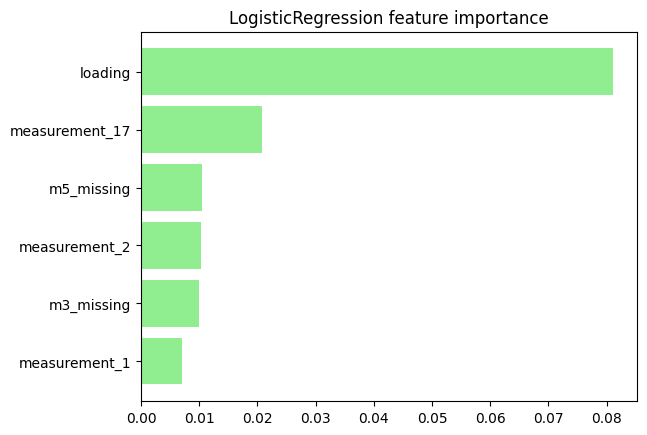

In [81]:
# variables
# lr_oof_1：LogisticRegression 在每個驗證集上預測的預測機率。
# lr_oof_2：LogisticRegression 在每個驗證集上預測的預測類別。
# lr_test：LogisticRegression 在測試資料集上預測的預測機率。
# lr_auc：LogisticRegression 在交叉驗證過程中的平均 AUC 值。
# lr_acc：LogisticRegression 在交叉驗證過程中的平均準確度。
# importance_list：LogisticRegression 在各個 fold 上的特徵重要性。

lr_oof_1 = np.zeros(len(X))
lr_oof_2 = np.zeros(len(X))
lr_test = np.zeros(len(test))
lr_auc = 0
lr_acc = 0
importance_list = []
model_list = ['./models/model1-1.pkl', './models/model1-2.pkl', './models/model1-3.pkl', './models/model1-4.pkl','./models/model1-5.pkl']

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print("Fold:", fold_idx+1)
    x_train, x_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    x_test = test.copy()
    x_train, x_val, x_test = _scale(x_train, x_val, x_test, select_feature)
    
    with open(model_list[fold_idx], 'rb') as f:
        model = pickle.load(f)

    # model.coef_ => weight(an array of weights estimated by linear regression)
    # ravel() => return contiguous flattened array (be 1D array)
    importance_list.append(model.coef_.ravel())

    val_preds = model.predict_proba(x_val[select_feature])[:, 1]
    lr_auc += roc_auc_score(y_val, val_preds) / 5
    y_preds = model.predict(x_val[select_feature])
    lr_acc += accuracy_score(y_val, y_preds) / 5
    lr_test += model.predict_proba(x_test[select_feature])[:, 1] / 5
    lr_oof_1[val_idx] = val_preds
    lr_oof_2[val_idx] = y_preds

print(f"{Fore.GREEN}{Style.BRIGHT}Average auc = {round(lr_auc, 5)}, Average acc = {round(lr_acc, 5)}{Style.RESET_ALL}")
print(f"{Fore.RED}{Style.BRIGHT}OOF auc = {round(roc_auc_score(y, lr_oof_1), 5)}, OOF acc = {round(accuracy_score(y, lr_oof_2), 5)}{Style.RESET_ALL}")

importance_df = pd.DataFrame(np.array(importance_list).T, index=x_train[select_feature].columns)
importance_df['mean'] = importance_df.mean(axis=1).abs()
importance_df['feature'] = x_train[select_feature].columns
importance_df = importance_df.sort_values('mean', ascending=False).reset_index().head(20)
plt.barh(importance_df.index, importance_df['mean'], color='lightgreen')
plt.gca().invert_yaxis()
plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
plt.title('LogisticRegression feature importance')
plt.show()

In [61]:
submission['lr0'] = lr_test

In [82]:
select_feature = ['measurement_1', 'measurement_2', 'loading', 'measurement_17']

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Average auc = 0.59032, Average acc = 0.78739
OOF auc = 0.59021, OOF acc = 0.78739


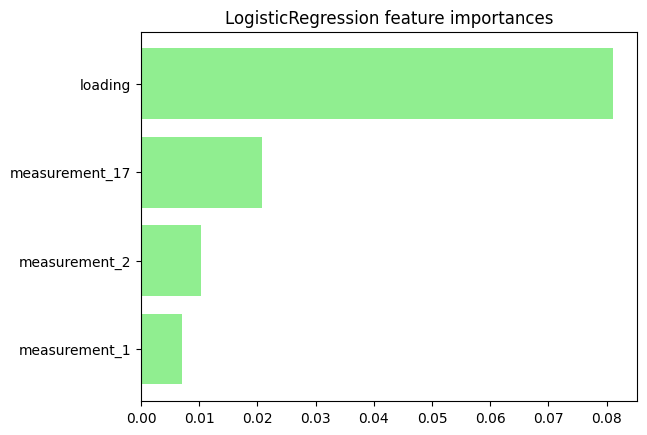

In [83]:
lr_oof_1 = np.zeros(len(X))
lr_oof_2 = np.zeros(len(X))
lr_test = np.zeros(len(test))
lr_auc = 0
lr_acc = 0
importance_list = []
model_list = ['./models/model2-1.pkl', './models/model2-2.pkl', './models/model2-3.pkl', './models/model2-4.pkl','./models/model2-5.pkl']

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print("Fold:", fold_idx+1)
    x_train, x_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    x_test = test.copy()
    x_train, x_val, x_test = _scale(x_train, x_val, x_test, select_feature)
    
    with open(model_list[fold_idx], 'rb') as f:
        model = pickle.load(f)
    importance_list.append(model.coef_.ravel())

    val_preds = model.predict_proba(x_val[select_feature])[:, 1]
    lr_auc += roc_auc_score(y_val, val_preds) / 5
    y_preds = model.predict(x_val[select_feature])
    lr_acc += accuracy_score(y_val, y_preds) / 5
    lr_test += model.predict_proba(x_test[select_feature])[:, 1] / 5
    lr_oof_1[val_idx] = val_preds
    lr_oof_2[val_idx] = y_preds

print(f"{Fore.GREEN}{Style.BRIGHT}Average auc = {round(lr_auc, 5)}, Average acc = {round(lr_acc, 5)}{Style.RESET_ALL}")
print(f"{Fore.RED}{Style.BRIGHT}OOF auc = {round(roc_auc_score(y, lr_oof_1), 5)}, OOF acc = {round(accuracy_score(y, lr_oof_2), 5)}{Style.RESET_ALL}")

importance_df = pd.DataFrame(np.array(importance_list).T, index=x_train[select_feature].columns)
importance_df['mean'] = importance_df.mean(axis=1).abs()
importance_df['feature'] = x_train[select_feature].columns
importance_df = importance_df.sort_values('mean', ascending=False).reset_index().head(20)
plt.barh(importance_df.index, importance_df['mean'], color='lightgreen')
plt.gca().invert_yaxis()
plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
plt.title('LogisticRegression feature importances')
plt.show()

In [64]:
submission['lr1'] = lr_test

new

In [84]:
select_feature = ['loading', 'measurement_17', 'm3_17_avg']

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Average auc = 0.58909, Average acc = 0.78739
OOF auc = 0.589, OOF acc = 0.78739


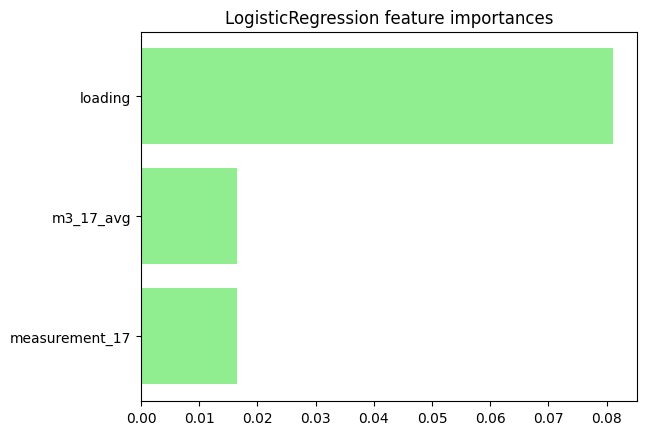

In [85]:
lr_oof_1 = np.zeros(len(X))
lr_oof_2 = np.zeros(len(X))
lr_test = np.zeros(len(test))
lr_auc = 0
lr_acc = 0
importance_list = []
model_list = ['./models/model3-1.pkl', './models/model3-2.pkl', './models/model3-3.pkl', './models/model3-4.pkl','./models/model3-5.pkl']

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print("Fold:", fold_idx+1)
    x_train, x_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    x_test = test.copy()
    
    x_train, x_val, x_test = _scale(x_train, x_val, x_test, select_feature)
    with open(model_list[fold_idx], 'rb') as f:
        model = pickle.load(f)
    importance_list.append(model.coef_.ravel())

    val_preds = model.predict_proba(x_val[select_feature])[:, 1]
    lr_auc += roc_auc_score(y_val, val_preds) / 5
    y_preds = model.predict(x_val[select_feature])
    lr_acc += accuracy_score(y_val, y_preds) / 5
    lr_test += model.predict_proba(x_test[select_feature])[:, 1] / 5
    lr_oof_1[val_idx] = val_preds
    lr_oof_2[val_idx] = y_preds

print(f"{Fore.GREEN}{Style.BRIGHT}Average auc = {round(lr_auc, 5)}, Average acc = {round(lr_acc, 5)}{Style.RESET_ALL}")
print(f"{Fore.RED}{Style.BRIGHT}OOF auc = {round(roc_auc_score(y, lr_oof_1), 5)}, OOF acc = {round(accuracy_score(y, lr_oof_2), 5)}{Style.RESET_ALL}")

importance_df = pd.DataFrame(np.array(importance_list).T, index=x_train[select_feature].columns)
importance_df['mean'] = importance_df.mean(axis=1).abs()
importance_df['feature'] = x_train[select_feature].columns
importance_df = importance_df.sort_values('mean', ascending=False).reset_index().head(20)
plt.barh(importance_df.index, importance_df['mean'], color='lightgreen')
plt.gca().invert_yaxis()
plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
plt.title('LogisticRegression feature importances')
plt.show()

In [86]:
submission['lr2'] = lr_test

In [87]:
submission.head()

,id,failure,lr0,lr1,lr2
0,26570,0.0,0.208906,0.208996,0.208252
1,26571,0.0,0.201129,0.201224,0.201619
2,26572,0.0,0.204884,0.204971,0.206438
3,26573,0.0,0.206612,0.206694,0.203775
4,26574,0.0,0.239220,0.239314,0.242482


In [88]:
submission['rank0'] = rankdata(submission['lr0'])
submission['rank1'] = rankdata(submission['lr1'])
submission['rank2'] = rankdata(submission['lr2'])

In [89]:
submission['failure'] = submission['rank0']*0.70 + submission['rank1']*0.05 + submission['rank2']*0.30

In [90]:
submission.head()

,id,failure,lr0,lr1,lr2,rank0,rank1,rank2
0,26570,9014.85,0.208906,0.208996,0.208252,8721.0,8715.0,8248.0
1,26571,4998.65,0.201129,0.201224,0.201619,4711.0,4685.0,4889.0
2,26572,7067.90,0.204884,0.204971,0.206438,6523.0,6500.0,7256.0
3,26573,7376.15,0.206612,0.206694,0.203775,7457.0,7431.0,5949.0
4,26574,21084.90,0.239220,0.239314,0.242482,20018.0,20084.0,20227.0


In [91]:
submission[['id', 'failure']].to_csv('submission.csv', index=False)